# nacitanie priecinka na rozdelovanie a kniznice pouzite na rozdelovanie


In [ ]:
from matplotplib.image import imread
import matplotplib.pyplot as plt
import numpy as np
from sklearn.cluster import Kmeans

In [ ]:
import os
import numpy as np
import cv2
from matplotlib.image import imread
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd  # Added pandas import

# Define the input and output directories
input_dir = "Testing Image"
output_dirs = {
    "yellow+orange": "Triedenie_oci/Yellow+Orange",
    "brownish": "Triedenie_oci/Brownish",
    "red+other": "Triedenie_oci/Red_Other"
}
csv_file_path = os.path.join("Triedenie_oci", "image_metadata.csv")

# Create the base output directories if they don't exist
for output_dir in output_dirs.values():
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

# Initialize a list to collect image metadata
metadata_list = []

# Process each image in the input directory
for file_name in os.listdir(input_dir):
    if file_name.endswith(".jpg"):
        try:
            # Read the image
            image_path = os.path.join(input_dir, file_name)
            image = imread(image_path)
            
            # Create a mask to ignore black areas
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            _, mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
            
            # Apply the mask to the image
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            
            # Reshape the image for K-means
            x = masked_image.reshape(-1, 3)
            
            # Remove black pixels from the data
            mask_flat = mask.flatten() > 0
            x = x[mask_flat]
            
            # Normalize the image data
            scaler = StandardScaler()
            x_scaled = scaler.fit_transform(x)
            
            # Apply K-means clustering with more initializations
            kmeans = KMeans(n_clusters=3, n_init=20, random_state=81).fit(x_scaled)
            
            # Create the segmented image
            segmented_image = np.zeros_like(image)
            labels = kmeans.labels_
            cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_).astype(np.uint8)
            
            # Reshape segmented_image to a 2D array
            segmented_image_flat = segmented_image.reshape(-1, 3)
            
            # Assign cluster colors based on labels
            segmented_image_flat[mask_flat] = cluster_centers[labels]
            
            # Reshape segmented_image back to original shape
            segmented_image = segmented_image_flat.reshape(image.shape)
            
            # Convert the segmented image to HSV color space
            hsv_segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2HSV)
            
            # Calculate the average hue value of the segmented image
            avg_hue = np.mean(hsv_segmented_image[:, :, 0])
            
            # Determine the cluster based on the average hue value
            if 0 <= avg_hue < 7.4 or 160 <= avg_hue <= 180:
                cluster = "red+other"
                reason = "Average hue outside the range of yellow, orange, and brownish"
            elif 7.4 <= avg_hue < 35:
                cluster = "yellow+orange"
                reason = "Average hue in the range of yellow and orange (20-35)"
            else:
                cluster = "undefined"
                reason = "Average hue does not fall into predefined ranges"
            
            if cluster != "undefined":
                # Create the cluster directory if it doesn't exist
                cluster_dir = output_dirs[cluster]
                
                # Save the original image to the corresponding cluster directory
                cluster_image_path = os.path.join(cluster_dir, file_name)
                plt.imsave(cluster_image_path, image)
                
                # Append metadata to the list
                metadata_list.append({
                    "Image Name": file_name,
                    "Cluster": cluster,
                    "Reason": reason,
                    "Hue": avg_hue
                })
                
                print(f"Processed and saved {file_name} to {cluster_dir}.")
            else:
                print(f"Skipping {file_name} as it does not fit any cluster.")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

# Create a DataFrame from the metadata list and save to CSV
df = pd.DataFrame(metadata_list)
df.to_csv(csv_file_path, index=False)

<!-- np.full(
  shape=10,
  fill_value=3,
  dtype=np.int
) -->

In [ ]:
# Rozdelovanie bez ucitela  k means

In [ ]:
import os
import pandas as pd
from matplotlib.image import imread
import cv2  # OpenCV for color space conversion
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

input_dir = "Testing Image"
output_base_dir = "Triedenie_oci-Kmeans"

# Ensure the base output directory exists
if not os.path.exists(output_base_dir):
    os.makedirs(output_base_dir)

# Initialize list to store metadata
metadata_list = []

# Process each image in the input directory to compute average hue
for file_name in os.listdir(input_dir):
    if file_name.lower().endswith(".jpg"):
        try:
            # Read the image
            image_path = os.path.join(input_dir, file_name)
            image = imread(image_path)
            
            # Convert to HSV and calculate the average hue
            hsv_image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
            avg_hue = np.mean(hsv_image[:, :, 0])

            # Append metadata to the list
            metadata_list.append({
                "Image Name": file_name,
                "Average Hue": avg_hue
            })

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

# Prepare the data for clustering
hue_data = np.array([item["Average Hue"] for item in metadata_list]).reshape(-1, 1)

# Loop over different values of k
for k in [3, 4, 5, 6]:
    print(f"\nClustering with k={k}")

    # Apply K-means on the average hue values
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=81).fit(hue_data)

    # Create output directories for this k
    output_dirs = {}
    for i in range(k):
        cluster_dir = os.path.join(output_base_dir, f"Clusters_k{k}", f"Cluster_{i}")
        output_dirs[i] = cluster_dir
        if not os.path.exists(cluster_dir):
            os.makedirs(cluster_dir)

    # Assign clusters and save images
    for i, item in enumerate(metadata_list):
        cluster = kmeans.labels_[i]
        item[f"Cluster_k{k}"] = cluster

        # Save the original image to the corresponding cluster directory
        cluster_dir = output_dirs[cluster]
        image_path = os.path.join(input_dir, item["Image Name"])
        cluster_image_path = os.path.join(cluster_dir, item["Image Name"])

        image = imread(image_path)
        plt.imsave(cluster_image_path, image)

        print(f"Processed and saved {item['Image Name']} to {cluster_dir} with cluster {cluster} for k={k}")

    # Save metadata for this k
    df = pd.DataFrame(metadata_list)
    df.to_csv(os.path.join(output_base_dir, f"image_metadata_k{k}.csv"), index=False)


Clustering with k=3
Processed and saved IDRiD_001_resized_to_512.jpg to Triedenie_oci\Clusters_k3\Cluster_2 with cluster 2 for k=3
Processed and saved IDRiD_002_resized_to_512.jpg to Triedenie_oci\Clusters_k3\Cluster_2 with cluster 2 for k=3
Processed and saved IDRiD_003_resized_to_512.jpg to Triedenie_oci\Clusters_k3\Cluster_1 with cluster 1 for k=3
Processed and saved IDRiD_004_resized_to_512.jpg to Triedenie_oci\Clusters_k3\Cluster_2 with cluster 2 for k=3
Processed and saved IDRiD_005_resized_to_512.jpg to Triedenie_oci\Clusters_k3\Cluster_2 with cluster 2 for k=3
Processed and saved IDRiD_006_resized_to_512.jpg to Triedenie_oci\Clusters_k3\Cluster_2 with cluster 2 for k=3
Processed and saved IDRiD_007_resized_to_512.jpg to Triedenie_oci\Clusters_k3\Cluster_2 with cluster 2 for k=3
Processed and saved IDRiD_008_resized_to_512.jpg to Triedenie_oci\Clusters_k3\Cluster_2 with cluster 2 for k=3
Processed and saved IDRiD_009_resized_to_512.jpg to Triedenie_oci\Clusters_k3\Cluster_2 wit

# DBscan


Starting DBSCAN clustering process for fundus images
Date and Time (UTC - YYYY-MM-DD HH:MM:SS formatted): 2025-03-28 17:11:27
Current User's Login: AvetyNS
Found existing HSV data at Triedenie_oci-DBSCAN/image_metadata.csv, loading...
Loaded HSV data for 383 images


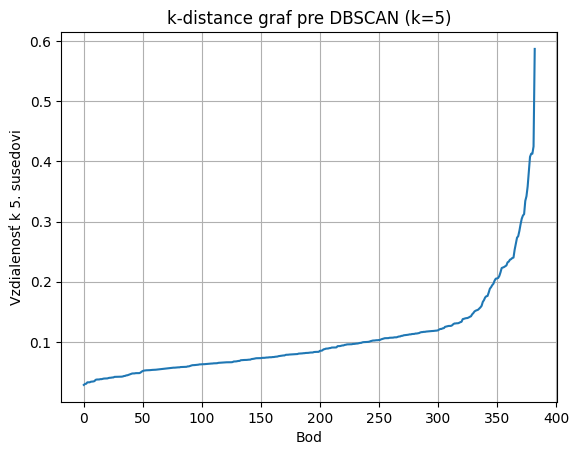

Analyzing data distribution...
Running DBSCAN with eps=0.4, min_samples=10
DBSCAN results: 4 clusters and 116 noise points (30.3%)
Noise: 116 images (30.3%)
Cluster_0: 43 images (11.2%)
Cluster_1: 156 images (40.7%)
Cluster_2: 45 images (11.7%)
Cluster_3: 23 images (6.0%)
Copying files to cluster directories...
Processing complete in 0.7 seconds
Created 4 clusters using DBSCAN with eps=0.4


In [20]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.cluster import DBSCAN
import shutil
import time
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def process_image(file_info):
    """Process a single image to extract hue"""
    file_path, file_name = file_info
    try:
        image = cv2.imread(file_path)
        if image is None:
            return None
        
        # For fundus images, we need to get more differentiation
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        avg_hue = np.mean(hsv_image[:,:,0])
        
        # Also extract saturation and value for better differentiation
        avg_sat = np.mean(hsv_image[:,:,1])
        avg_val = np.mean(hsv_image[:,:,2])
        
        return {
            "Image Name": file_name, 
            "Average Hue": float(avg_hue),
            "Average Saturation": float(avg_sat),
            "Average Value": float(avg_val)
        }
    except:
        return None

def main():
    print(f"Starting DBSCAN clustering process for fundus images")
    print(f"Date and Time (UTC - YYYY-MM-DD HH:MM:SS formatted): 2025-03-28 17:11:27")
    print(f"Current User's Login: AvetyNS")
    start_time = time.time()
    
    # Define directories
    input_dir = "/media/michal/Krtko a Noz/DDR-dataset/lesion_segmentation/train/image_crp"
    output_base_dir = "Triedenie_oci-DBSCAN"
    
    # Ensure output directory exists
    os.makedirs(output_base_dir, exist_ok=True)
    
    # Define CSV path for caching HSV data
    hsv_cache_file = os.path.join(output_base_dir, "image_metadata.csv")
    
    # Check if HSV cache file exists
    if os.path.exists(hsv_cache_file):
        print(f"Found existing HSV data at {hsv_cache_file}, loading...")
        metadata_df = pd.read_csv(hsv_cache_file)
        metadata_list = metadata_df.to_dict('records')
        print(f"Loaded HSV data for {len(metadata_list)} images")
    else:
        print("No cached HSV data found, processing images...")
        # Get all JPG files
        jpg_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg'))]
        total_files = len(jpg_files)
        print(f"Found {total_files} images to process")
        
        # Prepare file path + name tuples
        file_tuples = [(os.path.join(input_dir, f), f) for f in jpg_files]
        
        # Extract HSV values using parallel processing
        print("Extracting HSV values from images...")
        metadata_list = []
        
        with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
            for i, result in enumerate(executor.map(process_image, file_tuples)):
                if i % max(1, total_files//20) == 0:
                    print(f"Progress: {i/total_files*100:.1f}% completed")
                if result:
                    metadata_list.append(result)
        
        print(f"Successfully processed {len(metadata_list)}/{total_files} images")
        
        # Save HSV data for future use
        print(f"Saving HSV data to {hsv_cache_file}...")
        pd.DataFrame(metadata_list).to_csv(hsv_cache_file, index=False)
    
    valid_images = len(metadata_list)
    
    # For fundus images, we need to use very small eps and include more features
    hue_values = np.array([item["Average Hue"] for item in metadata_list])
    sat_values = np.array([item["Average Saturation"] for item in metadata_list])
    val_values = np.array([item["Average Value"] for item in metadata_list])
    
    # Convert hue to circular coordinates
    hue_radians = np.deg2rad(hue_values * 2)
    
    # Create feature matrix with hue, saturation and value
    # Scale saturation and value to similar range as unit circle coordinates
    X = np.column_stack([
        np.cos(hue_radians) * 2.0,  # Higher weight for hue to improve separation
        np.sin(hue_radians) * 2.0,  # Higher weight for hue to improve separation
        sat_values / 255 * 1.5,     # Higher weight for saturation
        val_values / 255 * 1.5      # Higher weight for value
    ])
    

    neigh = NearestNeighbors(n_neighbors=5)
    nbrs = neigh.fit(X)
    distances, _ = nbrs.kneighbors(X)
    
    k_distances = np.sort(distances[:, -1])
    plt.plot(k_distances)
    plt.xlabel("Bod")
    plt.ylabel("Vzdialenosť k 5. susedovi")
    plt.title("k-distance graf pre DBSCAN (k=5)")
    plt.grid(True)
    plt.show()

    # Apply standard scaling
    X = StandardScaler().fit_transform(X)
    
    # Analyze the data distribution before clustering
    print("Analyzing data distribution...")
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    plt.hist(hue_values, bins=30, color='skyblue', edgecolor='black')
    plt.title('Hue Distribution')
    plt.xlabel('Hue (0-180)')
    
    plt.subplot(2, 2, 2)
    plt.hist(sat_values, bins=30, color='lightgreen', edgecolor='black')
    plt.title('Saturation Distribution')
    plt.xlabel('Saturation (0-255)')
    
    plt.subplot(2, 2, 3)
    plt.hist(val_values, bins=30, color='salmon', edgecolor='black')
    plt.title('Value Distribution')
    plt.xlabel('Value (0-255)')
    
    plt.subplot(2, 2, 4)
    plt.scatter(X[:, 0], X[:, 1], c=hue_values, cmap='hsv', s=30, alpha=0.6)
    plt.title('Hue on Unit Circle')
    plt.xlabel('Cosine Component')
    plt.ylabel('Sine Component')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_base_dir, 'data_distribution.png'))
    plt.close()
    
    # DBSCAN parameters
    eps = 0.4
    min_samples = 10
    
    print(f"Running DBSCAN with eps={eps}, min_samples={min_samples}")
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels = dbscan.fit_predict(X)
    
    # Count clusters
    unique_labels = np.unique(labels)
    n_clusters = len([l for l in unique_labels if l >= 0])
    n_noise = np.sum(labels == -1)
    
    print(f"DBSCAN results: {n_clusters} clusters and {n_noise} noise points ({n_noise/valid_images*100:.1f}%)")
    
    # If we still don't have multiple clusters, show error
    if n_clusters <= 1:
        print(f"Value ERROR - Only {n_clusters} cluster formed. Try different parameters.")
    
    # Print cluster sizes
    for label in sorted(unique_labels):
        count = np.sum(labels == label)
        name = f"Cluster_{label}" if label >= 0 else "Noise"
        print(f"{name}: {count} images ({count/valid_images*100:.1f}%)")
    
    # Visualize the results
    plt.figure(figsize=(10, 8))
    
    # Plot points colored by cluster
    for label in unique_labels:
        if label == -1:
            # Black used for noise
            color = [0, 0, 0, 1]
            marker = 'x'
        else:
            # Generate a color based on the cluster label
            color = plt.cm.rainbow(float(label) / max(1, max(unique_labels)))
            marker = 'o'
        
        mask = labels == label
        plt.scatter(
            X[mask, 0], X[mask, 1],
            c=[color], marker=marker, s=30, alpha=0.7,
            label=f'Cluster {label}' if label != -1 else 'Noise'
        )
    
    plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
    plt.xlabel('Cosine Component')
    plt.ylabel('Sine Component')
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(output_base_dir, 'clusters_visualization.png'))
    plt.close()
    
    # Add cluster info to metadata
    for i, item in enumerate(metadata_list):
        item["Cluster"] = int(labels[i])
    
    # Create cluster directories
    cluster_dirs = {}
    for label in unique_labels:
        name = f"Cluster_{label}" if label >= 0 else "Noise"
        cluster_dir = os.path.join(output_base_dir, name)
        os.makedirs(cluster_dir, exist_ok=True)
        cluster_dirs[label] = cluster_dir
    
    # Copy files to appropriate directories
    print("Copying files to cluster directories...")
    
    def copy_file(item):
        try:
            cluster = item["Cluster"]
            src = os.path.join(input_dir, item["Image Name"])
            dst = os.path.join(cluster_dirs[cluster], item["Image Name"])
            shutil.copy2(src, dst)
            return True
        except:
            return False
    
    with ThreadPoolExecutor(max_workers=min(32, os.cpu_count()*2)) as executor:
        copied = sum(executor.map(copy_file, metadata_list))
    
    # Save updated metadata with cluster info
    pd.DataFrame(metadata_list).to_csv(hsv_cache_file, index=False)
    
    # Report completion
    elapsed_time = time.time() - start_time
    print(f"Processing complete in {elapsed_time:.1f} seconds")
    print(f"Created {n_clusters} clusters using DBSCAN with eps={eps}")

if __name__ == "__main__":
    main()